In [1]:
#Plot 5 - Fraction of 

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [3]:
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [5]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number netween 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [6]:
########## CONUS ############
#CONUS lat-lon
ctop    = 50.0 # north lat
cleft   = (360-124.7844079)%360 # west long
cright  = (360-66.9513812)%360# east long
cbottom =  24.7433195 # south lat
################################
#Europe lat-lon
eutop     = 60.0
eubottom  = 35.0
euleft    = (360-10.0)%360
euright   = 50

################################
cesm2_path    = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
landfrac_path = '/global/scratch/users/harsha/LENS/cesm2/landfrac/'
cvals         = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals1        = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
cvals_det     = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
##############################
print(cleft,cright)
print(euleft,euright)

235.21559209999998 293.0486188
350.0 50


In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(4)

In [8]:
cluster

In [9]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [10]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [11]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [12]:
def global_annual_rmse(arr_err, dim):
      #Compute spatially weighted global mean of square error
      # and then compute annual rmse #g = global, a= annual
        arr_err_sq            = arr_err**2
        weights               = np.cos(np.deg2rad(arr_err_sq.lat))
        weights.name          = "weights"
        arr_serror_weighted   = arr_err_sq.weighted(weights)
        arr_serror_gmean      = arr_serror_weighted.mean({'lat','lon'},skipna=True)
        ####
        arr_gamse             = arr_serror_gmean.mean(dim)
        arr_garmse            = np.sqrt(arr_gamse)
        
        return arr_garmse

In [13]:
cluster

In [14]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [15]:
%%time 
landfrac = xr.open_mfdataset(landfrac_path+'*.nc',engine='netcdf4')
landfrac = landfrac.LANDFRAC
landfrac

CPU times: user 346 ms, sys: 72.1 ms, total: 418 ms
Wall time: 596 ms


<xarray.DataArray 'LANDFRAC' (time: 192, lat: 192, lon: 288)>
dask.array<concatenate, shape=(192, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by land
    cell_methods:  time: mean

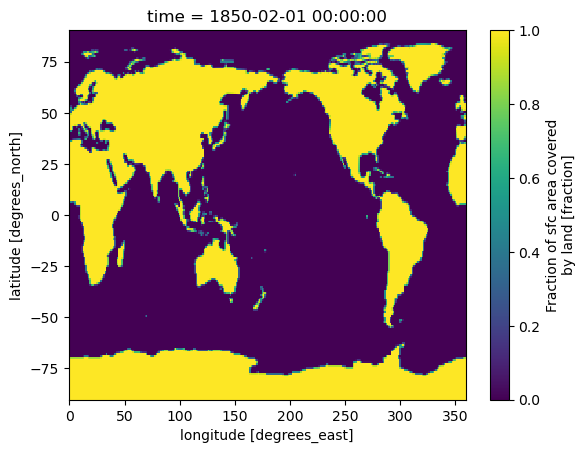

In [16]:
landfrac.sel(time='18500201').plot()

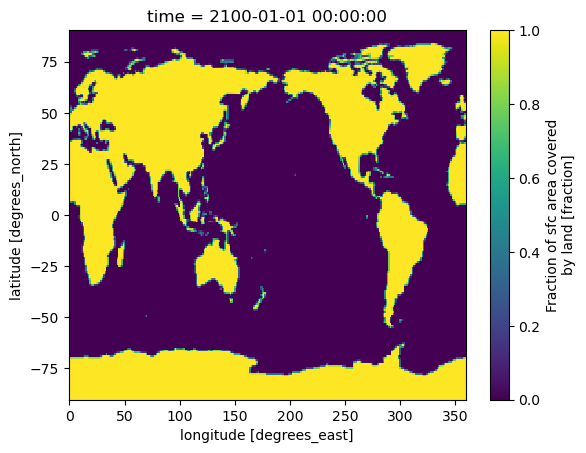

In [17]:
landfrac.sel(time='21000101').plot()

In [18]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 3.21 s, sys: 388 ms, total: 3.6 s
Wall time: 9.5 s


In [19]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
#tgnw

CPU times: user 239 ms, sys: 5.77 ms, total: 244 ms
Wall time: 237 ms


In [20]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 2.11 s, sys: 140 ms, total: 2.25 s
Wall time: 2.19 s


,Array,Chunk
Bytes,451.13 GiB,205.99 MiB
Shape,"(21900, 192, 288, 100)","(900, 20, 30, 100)"
Count,57502 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [24]:
%%time
########### Save the absolute errors ############
#DJF
qgmsc_djf_errpath     = cvals_det+'qgmsc_detssn_err_'   +'djf' +'_'+ic_year0+'_'+ic_year1+'.zarr' 
qgauss_djf_errpath    = cvals_det+'qgauss_detssn_err_'  +'djf' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_djf_errpath      = cvals_det+'qgmc_detssn_err_'    +'djf' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_djf_errpath  = cvals_det+'qgaussmo_detssn_err_'+'djf' +'_'+ic_year0+'_'+ic_year1+'.zarr'
#MAM
qgmsc_mam_errpath     = cvals_det+'qgmsc_detssn_err_'   +'mam' +'_'+ic_year0+'_'+ic_year1+'.zarr' 
qgauss_mam_errpath    = cvals_det+'qgauss_detssn_err_'  +'mam' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_mam_errpath      = cvals_det+'qgmc_detssn_err_'    +'mam' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_mam_errpath   = cvals_det+'qgaussmo_detssn_err_'+'mam' +'_'+ic_year0+'_'+ic_year1+'.zarr'
#JJA
qgmsc_jja_errpath     = cvals_det+'qgmsc_detssn_err_'   +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr' 
qgauss_jja_errpath    = cvals_det+'qgauss_detssn_err_'  +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_jja_errpath      = cvals_det+'qgmc_detssn_err_'    +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_jja_errpath    = cvals_det+'qgaussmo_detssn_err_'+'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'
#SON
qgmsc_son_errpath     = cvals_det+'qgmsc_detssn_err_'   +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr' 
qgauss_son_errpath    = cvals_det+'qgauss_detssn_err_'  +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_son_errpath      = cvals_det+'qgmc_detssn_err_'    +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_son_errpath    = cvals_det+'qgaussmo_detssn_err_'+'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'

CPU times: user 55 µs, sys: 0 ns, total: 55 µs
Wall time: 80.8 µs


In [25]:
##### Open ########
qgmsc_djf_err    = xr.open_zarr(qgmsc_djf_errpath).Errors
qgauss_djf_err   = xr.open_zarr(qgauss_djf_errpath).Errors
qgmc_djf_err     = xr.open_zarr(qgmc_djf_errpath).Errors
qgaussmo_djf_err   = xr.open_zarr(qgaussmo_djf_errpath).Errors

In [26]:
##### Open ########
qgmsc_mam_err     = xr.open_zarr(qgmsc_mam_errpath).Errors
qgauss_mam_err    = xr.open_zarr(qgauss_mam_errpath).Errors
qgmc_mam_err      = xr.open_zarr(qgmc_mam_errpath).Errors
qgaussmo_mam_err  = xr.open_zarr(qgaussmo_mam_errpath).Errors

In [27]:
##### Open ########
qgmsc_jja_err    = xr.open_zarr(qgmsc_jja_errpath).Errors
qgauss_jja_err   = xr.open_zarr(qgauss_jja_errpath).Errors
qgmc_jja_err     = xr.open_zarr(qgmc_jja_errpath).Errors
qgaussmo_jja_err   = xr.open_zarr(qgaussmo_jja_errpath).Errors

In [28]:
##### Open ########
qgmsc_son_err    = xr.open_zarr(qgmsc_son_errpath).Errors
qgauss_son_err   = xr.open_zarr(qgauss_son_errpath).Errors
qgmc_son_err     = xr.open_zarr(qgmc_son_errpath).Errors
qgaussmo_son_err = xr.open_zarr(qgaussmo_son_errpath).Errors

In [29]:
####### Plot errors for all seasons #############

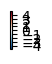

In [30]:
######## New colorbar only for shift + stretch and gaussian ############
x = 5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

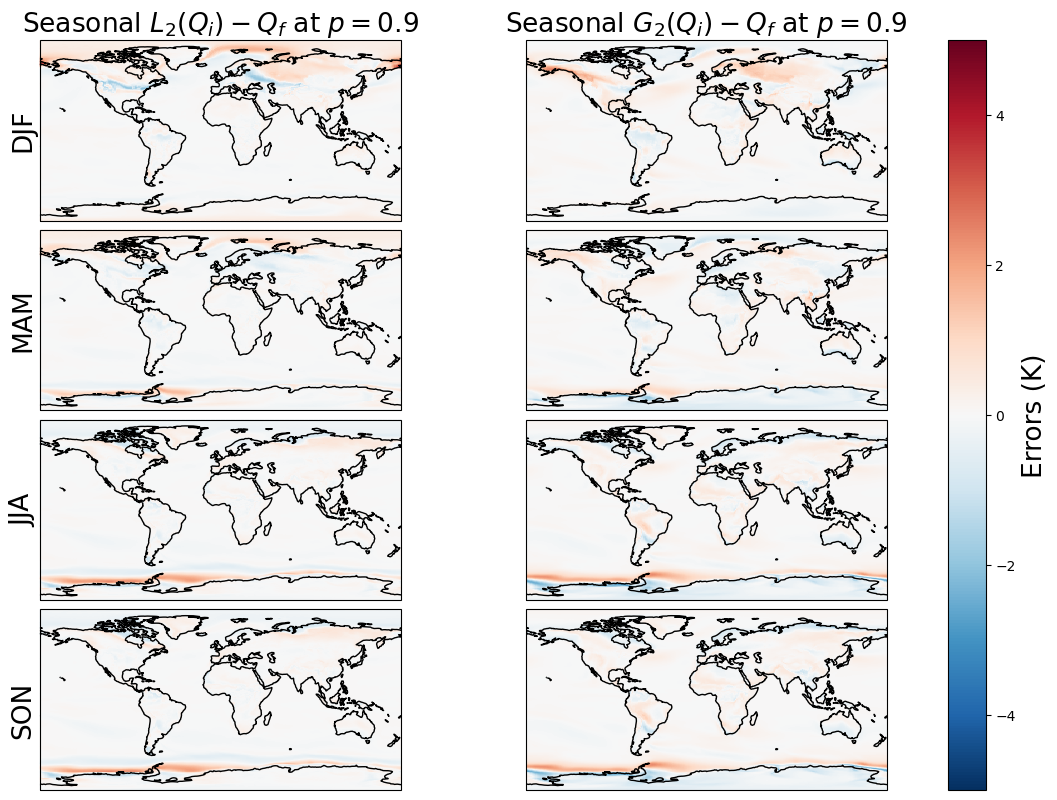

CPU times: user 1min 48s, sys: 6.68 s, total: 1min 54s
Wall time: 2min 13s


In [87]:
%%time
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(13.5,10), 
                        subplot_kw={'projection': cart.crs.PlateCarree()}) 
                        #gridspec_kw = {'wspace':0.02, 'hspace':0.01,'top':0.4,'bottom':0.1})

# # Reduce the padding around each subplot
#plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Adding titles for the rows
fig.text(0.12, 0.86, 'DJF', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.67, 'MAM', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.48, 'JJA', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.28, 'SON', va='center', rotation='vertical',fontsize=19)

# Plotting qgmsc_err1
im1= qgmsc_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[0, 0].coastlines(color="black")
axs[0, 0].set_title(r'Seasonal $L_2(Q_i) - Q_f$ at $p=0.9$',fontsize=19)
#
im2 = qgmsc_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[1, 0].coastlines(color="black")
axs[1, 0].set_title('')
#
im3 = qgmsc_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[2, 0].coastlines(color="black")
axs[2, 0].set_title('')
#
im4 = qgmsc_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[3, 0].coastlines(color="black")
axs[3, 0].set_title('')

##### DJF #################
# # Plotting qgauss_err1
im5 = qgauss_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[0, 1].coastlines(color="black")
axs[0, 1].set_title(r'Seasonal $G_2(Q_i) - Q_f$ at $p=0.9$',fontsize=19)

######## Plotting MAM #######################
# Plotting qgauss_err1
im6 = qgauss_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[1, 1].coastlines(color="black")
axs[1, 1].set_title('')

######## Plotting JJA #######################

# Plotting qgauss_err1
im7 = qgauss_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[2, 1].coastlines(color="black")
axs[2, 1].set_title('')
######## Plotting SON #######################

# Plotting qgauss_err1
im8 = qgauss_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[3, 1].coastlines(color="black")
axs[3, 1].set_title('')

# Creating a mappable object for the colorbar
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.05, right=0.95,
                    wspace=0.001, hspace=0.05)

# Adding colorbar
cbar = plt.colorbar(mappable, ax=axs.ravel().tolist(), shrink=1, orientation='vertical')
cbar.set_label('Errors (K)',fontsize=19)
#fig.tight_layout()
plt.show()

In [32]:
%%time
qgmsc_err = xr.concat([qgmsc_djf_err,qgmsc_mam_err,qgmsc_jja_err,qgmsc_son_err],dim='day')
qgmc_err  = xr.concat([qgmc_djf_err,qgmc_mam_err,qgmc_jja_err,qgmc_son_err],dim='day')
#qgmsc_err

CPU times: user 103 ms, sys: 28.5 ms, total: 131 ms
Wall time: 148 ms


In [33]:
%%time
qgauss_err = xr.concat([qgauss_djf_err,qgauss_mam_err,qgauss_jja_err,qgauss_son_err],dim='day')
qgaussmo_err = xr.concat([qgaussmo_djf_err,qgaussmo_mam_err,qgaussmo_jja_err,qgaussmo_son_err],dim='day')
#qgauss_err

CPU times: user 183 ms, sys: 34.6 ms, total: 218 ms
Wall time: 230 ms


In [88]:
qgaussmo_err.values

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [89]:
qgaussmo_err

,Array,Chunk
Bytes,15.23 GiB,6.16 MiB
Shape,"(101, 192, 288, 366)","(101, 20, 40, 10)"
Count,5443 Tasks,3120 Chunks
Type,float64,numpy.ndarray


In [34]:
# Take a zonal average (weighted mean over longitude)
# weights      = np.cos(np.deg2rad(qgmsc_err.lat))
# weights.name = "weights"
# #
# qgmsc_err_weighted     = qgmsc_err.weighted(weights)
# qgauss_err_weighted    = qgauss_err.weighted(weights)
# #
# qgmsc_err_zmean     = qgmsc_err_weighted.mean('lon')
# qgauss_err_zmean    = qgauss_err_weighted.mean('lon')

In [38]:
##### Get masked arrays for land and ocean #############

In [39]:
%%time
landfrac        = landfrac.sel(time='21000101')
qgmsc_abserr    = (np.fabs(qgmsc_err) < 1.0)
qgauss_abserr   = (np.fabs(qgauss_err) < 1.0)
qgauss_abserr

CPU times: user 11.6 ms, sys: 941 µs, total: 12.6 ms
Wall time: 11.8 ms


,Array,Chunk
Bytes,1.90 GiB,789.06 kiB
Shape,"(101, 192, 288, 366)","(101, 20, 40, 10)"
Count,11683 Tasks,3120 Chunks
Type,bool,numpy.ndarray


In [40]:
%%time
M                     = 192*288*365
qgmsc_err_fracn1      = qgmsc_abserr.sum({'day','lat','lon'})/M
qgauss_err_fracn1     = qgauss_abserr.sum({'day','lat','lon'})/M
#### Land #######
qgmsc_land_errfracn1  = qgmsc_abserr.where(landfrac==1).mean({'day','lat','lon'},skipna=True)
qgauss_land_errfracn1 = qgauss_abserr.where(landfrac==1).mean({'day','lat','lon'},skipna=True)
#### Ocean ######
qgmsc_ocean_errfracn1 = qgmsc_abserr.where(landfrac==0).mean({'day','lat','lon'},skipna=True)
qgauss_ocean_errfracn1= qgauss_abserr.where(landfrac==0).mean({'day','lat','lon'},skipna=True)

CPU times: user 901 ms, sys: 88.1 ms, total: 989 ms
Wall time: 966 ms


In [41]:
#landfrac.values

In [42]:
# %%time
M                      = 192*288*365
# qgmw_diff_fracn0.5     = (np.fabs(qgmw_diff) < 0.5).sum({'day','lat','lon'})/M
# qgmw_reldiff1_fracn0.5 = (np.fabs(qgmw_reldiff1) < 0.5).sum({'day','lat','lon'})/M
# qgmw_reldiff2_fracn0.5 = (np.fabs(qgmw_reldiff2) < 0.5).sum({'day','lat','lon'})/M

In [43]:
# qgmsc_err_chk      = (np.fabs(qgmsc_err) < 1.0)
# qgmsc_land_err_chk = qgmsc_err_chk.where(landfrac==1).mean(['day','lat','lon'],skipna=True)
# qgmsc_land_err_chk.plot()

In [44]:
# qgmsc_land_err_chk2 = (np.fabs(qgmsc_land_err) < 1.0)
# qgmsc_land_err_chk2.sum('day').sel(quantile=0.5).plot()

In [45]:
quants = np.arange(0.0,1.01,0.01)

In [46]:
%%time
########### Save the fracn of errors <1K  ############
qgmsc_errfracn1path           = cvals+'qgmsc_err<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_errfracn1path          = cvals+'qgauss_err<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#### Land #######
qgmsc_land_errfracn1path   = cvals+'qgmsc_err_land<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_land_errfracn1path  = cvals+'qgauss_err_land<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##### Ocean #####
qgmsc_ocean_errfracn1path  = cvals+'qgmsc_err_ocean<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_ocean_errfracn1path = cvals+'qgauss_err_ocean<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
########################################
# qgmsc_land_errfracn1.to_dataset().to_zarr(qgmsc_land_errfracn1path,mode='w')
# qgauss_land_errfracn1.to_dataset().to_zarr(qgauss_land_errfracn1path,mode='w')
# #
# qgmsc_ocean_errfracn1.to_dataset().to_zarr(qgmsc_ocean_errfracn1path,mode='w')
# qgauss_ocean_errfracn1.to_dataset().to_zarr(qgauss_ocean_errfracn1path,mode='w')
# #
# qgmsc_err_fracn1.to_dataset().to_zarr(qgmsc_errfracn1path,mode='w')
# qgauss_err_fracn1.to_dataset().to_zarr(qgauss_errfracn1path,mode='w')

CPU times: user 2min 59s, sys: 8.15 s, total: 3min 7s
Wall time: 3min 38s


In [47]:
########### Open and PLot ############
qgmsc_land_errfracn1  = xr.open_zarr(qgmsc_land_errfracn1path).Errors
qgauss_land_errfracn1 = xr.open_zarr(qgauss_land_errfracn1path).Errors
#
qgmsc_ocean_errfracn1 = xr.open_zarr(qgmsc_ocean_errfracn1path).Errors
qgauss_ocean_errfracn1= xr.open_zarr(qgauss_ocean_errfracn1path).Errors
#
qgmsc_errfracn1       = xr.open_zarr(qgmsc_errfracn1path).Errors
qgauss_errfracn1      = xr.open_zarr(qgauss_errfracn1path).Errors

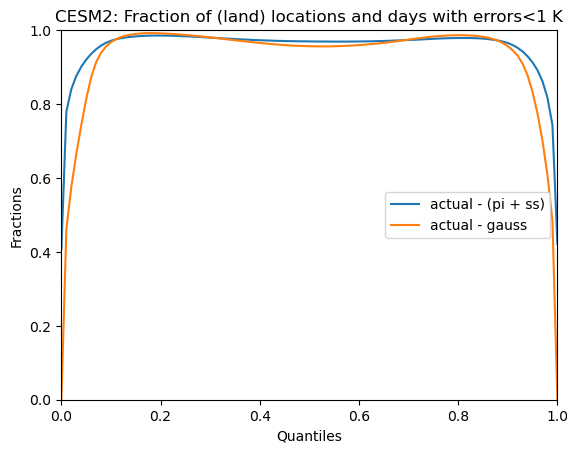

CPU times: user 559 ms, sys: 51.2 ms, total: 610 ms
Wall time: 636 ms


In [48]:
%%time
quants = np.arange(0,1.01,0.01)
plt.plot(quants,qgmsc_land_errfracn1,label='actual - (pi + ss)', c='tab:blue')
plt.plot(quants,qgauss_land_errfracn1,label='actual - gauss',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Fraction of (land) locations and days with errors<1 K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

In [49]:
#qgmw_reldiff2_fracn0.values

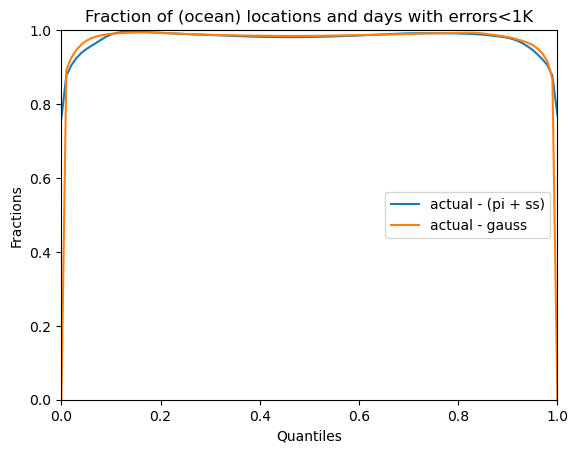

CPU times: user 598 ms, sys: 47.8 ms, total: 646 ms
Wall time: 655 ms


In [50]:
%%time
plt.plot(quants,qgmsc_ocean_errfracn1,label='actual - (pi + ss)', c='tab:blue')
plt.plot(quants,qgauss_ocean_errfracn1,label='actual - gauss',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('Fraction of (ocean) locations and days with errors<1K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

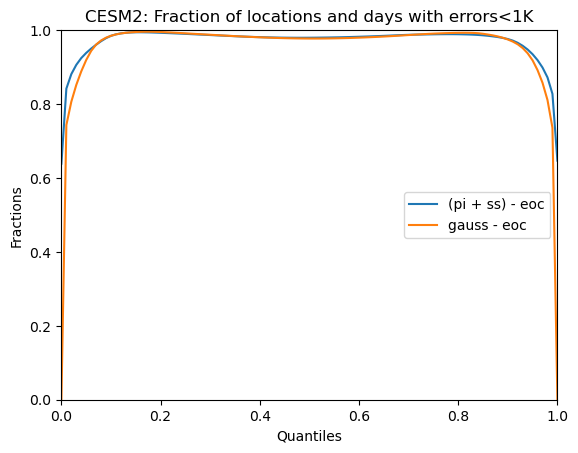

CPU times: user 646 ms, sys: 42 ms, total: 688 ms
Wall time: 680 ms


In [51]:
%%time
plt.plot(quants,qgmsc_errfracn1,label='(pi + ss) - eoc', c='tab:blue')
plt.plot(quants,qgauss_errfracn1,label='gauss - eoc',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Fraction of locations and days with errors<1K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

In [52]:
############# Plot 4 ################

In [53]:
# %%time
# #Quantile q=0.1
# #Plot 4c
# levs     = np.arange(-4,4.4,0.4)
# ax       = plt.axes(projection=cart.crs.PlateCarree())
# qgmw_son_reldiff2.sel(quantile=0.9).mean('day')\
# .plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs,cmap=cmap_divergent)
# plt.plot(-87.629,41.94,marker='*')
# plt.plot(77.5,12.72,marker='*')
# ax.coastlines(color="black")
# #ax.gridlines()
# #plt.title('q=0.9,'+r'$\delta t_w - 0$')
# plt.title('q=0.9, actual - (pi + shift + stretch), SON mean')

In [54]:
############## Plot 5 #########################

In [55]:
############# Compute area-weighted mean square of the above errors #####################

In [56]:
# g = global, l=land, o=ocean
qgmsc_grmse     = global_annual_rmse(qgmsc_err,'day')
qgauss_grmse    = global_annual_rmse(qgauss_err,'day')
qgmc_grmse      = global_annual_rmse(qgmc_err,'day')
qgaussmo_grmse  = global_annual_rmse(qgaussmo_err,'day')
qgmsc_lrmse     = global_annual_rmse(qgmsc_err.where(landfrac==1),'day')
qgauss_lrmse    = global_annual_rmse(qgauss_err.where(landfrac==1),'day')
qgmsc_ormse     = global_annual_rmse(qgmsc_err.where(landfrac==0),'day')
qgauss_ormse    = global_annual_rmse(qgauss_err.where(landfrac==0),'day')

In [57]:
qgmsc_lrmse

<xarray.DataArray 'Errors' (quantile: 101, time: 1)>
dask.array<sqrt, shape=(101, 1), dtype=float64, chunksize=(101, 1), chunktype=numpy.ndarray>
Coordinates:
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 2086
    ym        int64 2086
  * time      (time) object 2100-01-01 00:00:00

In [59]:
%%time
# qgmw_grmsepath   = cvals+'qgmw_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_grmsepath   = cvals+'qgmc_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_grmsepath  = cvals+'qgmsc_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_grmsepath = cvals+'qgauss_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_grmsepath = cvals+'qgaussmo_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_lrmsepath  = cvals+'qgmsc_land_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_lrmsepath = cvals+'qgauss_land_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_ormsepath  = cvals+'qgmsc_ocean_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_ormsepath = cvals+'qgauss_ocean_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##########################
# qgmc_grmse.to_dataset().to_zarr(qgmc_grmsepath,mode='w')
# qgmsc_grmse.to_dataset().to_zarr(qgmsc_grmsepath,mode='w')
# qgauss_grmse.to_dataset().to_zarr(qgauss_grmsepath,mode='w')
qgaussmo_grmse.to_dataset().to_zarr(qgaussmo_grmsepath,mode='w')
# #
# qgmsc_lrmse.to_dataset().to_zarr(qgmsc_lrmsepath,mode='w')
# qgauss_lrmse.to_dataset().to_zarr(qgauss_lrmsepath,mode='w')
# #
# qgmsc_ormse.to_dataset().to_zarr(qgmsc_ormsepath,mode='w')
# qgauss_ormse.to_dataset().to_zarr(qgauss_ormsepath,mode='w')

CPU times: user 6min 21s, sys: 18.2 s, total: 6min 39s
Wall time: 6min 45s


In [73]:
%%time
# qgmw_grmse   = xr.open_zarr(qgmw_grmsepath)
qgmc_grmse   = xr.open_zarr(qgmc_grmsepath).Errors
qgmsc_grmse  = xr.open_zarr(qgmsc_grmsepath).Errors
qgauss_grmse = xr.open_zarr(qgauss_grmsepath).Errors
qgaussmo_grmse = xr.open_zarr(qgaussmo_grmsepath).Errors
qgmsc_lrmse  = xr.open_zarr(qgmsc_lrmsepath).Errors
qgauss_lrmse = xr.open_zarr(qgauss_lrmsepath).Errors
qgmsc_ormse  = xr.open_zarr(qgmsc_ormsepath).Errors
qgauss_ormse = xr.open_zarr(qgauss_ormsepath).Errors

CPU times: user 186 ms, sys: 45.7 ms, total: 232 ms
Wall time: 223 ms


In [74]:
qgauss_grmse.loc[dict(quantile=0)]=1e10
qgauss_grmse.loc[dict(quantile=1)]=1e10
qgauss_grmse.values

array([1.00000000e+10, 9.33321559e-01, 7.23711406e-01, 6.00890438e-01,
       5.14482741e-01, 4.48555653e-01, 3.95991958e-01, 3.53049265e-01,
       3.17522271e-01, 2.88018736e-01, 2.63553625e-01, 2.43522567e-01,
       2.27422015e-01, 2.14896179e-01, 2.05543315e-01, 1.99038084e-01,
       1.95067147e-01, 1.93238913e-01, 1.93218323e-01, 1.94681326e-01,
       1.97308195e-01, 2.00872407e-01, 2.05124856e-01, 2.09882478e-01,
       2.14961965e-01, 2.20234007e-01, 2.25632839e-01, 2.31047745e-01,
       2.36403793e-01, 2.41658884e-01, 2.46769829e-01, 2.51708181e-01,
       2.56455765e-01, 2.60969045e-01, 2.65264235e-01, 2.69323013e-01,
       2.73124613e-01, 2.76658438e-01, 2.79931989e-01, 2.82942213e-01,
       2.85669048e-01, 2.88119763e-01, 2.90294784e-01, 2.92198303e-01,
       2.93832892e-01, 2.95193228e-01, 2.96270934e-01, 2.97087091e-01,
       2.97641639e-01, 2.97918724e-01, 2.97930241e-01, 2.97660857e-01,
       2.97115091e-01, 2.96307100e-01, 2.95227004e-01, 2.93880289e-01,
      

In [75]:
qgaussmo_grmse.loc[dict(quantile=0)]=1e10
qgaussmo_grmse.loc[dict(quantile=1)]=1e10
qgaussmo_grmse.values

array([1.e+10, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+10])

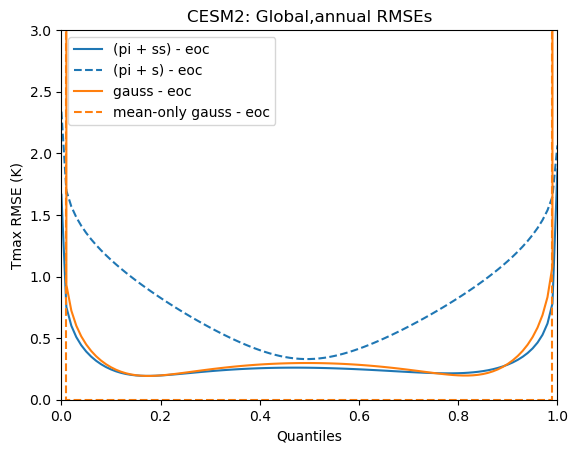

CPU times: user 3.38 s, sys: 238 ms, total: 3.62 s
Wall time: 7.73 s


In [76]:
%%time
plt.plot(quants,qgmsc_grmse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgmc_grmse,'--',label = '(pi + s) - eoc',color='tab:blue')
plt.plot(quants,qgauss_grmse,label='gauss - eoc',color='tab:orange')
plt.plot(quants,qgaussmo_grmse,'--',label = 'mean-only gauss - eoc',color='tab:orange')
plt.legend(loc='upper left')
plt.title('CESM2: Global,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

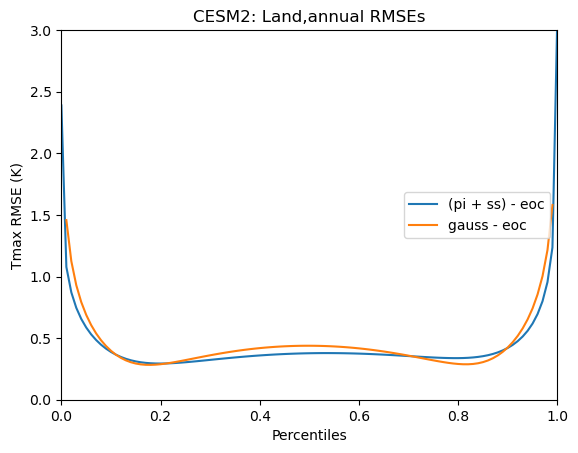

CPU times: user 638 ms, sys: 58 ms, total: 696 ms
Wall time: 695 ms


In [77]:
%%time
plt.plot(quants,qgmsc_lrmse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgauss_lrmse,label='gauss - eoc',color='tab:orange')
plt.legend(loc='center right')
plt.title('CESM2: Land,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

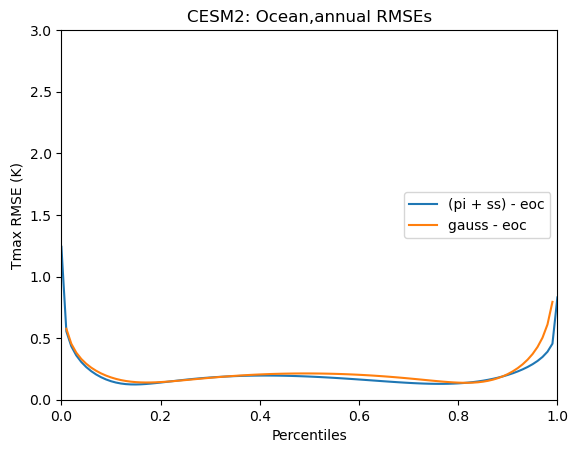

CPU times: user 664 ms, sys: 51.5 ms, total: 715 ms
Wall time: 702 ms


In [78]:
%%time
plt.plot(quants,qgmsc_ormse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgauss_ormse,label='gauss - eoc',color='tab:orange')
plt.legend(loc='center right')
plt.title('CESM2: Ocean,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

In [79]:
#qgmsc_lrmse.values

In [80]:
#qgauss_lrmse.values

In [81]:
#qgmsc_ormse.values

In [82]:
#qgauss_ormse.values

CPU times: user 8.19 s, sys: 510 ms, total: 8.7 s
Wall time: 20.5 s


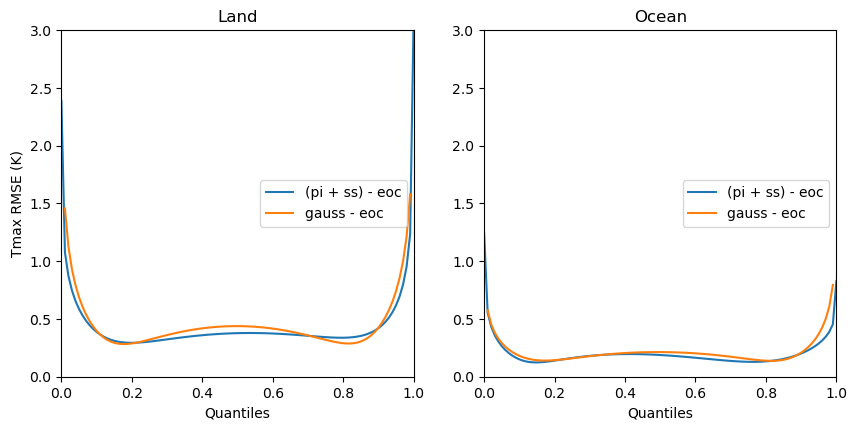

In [83]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

qgmsc_lrmse.plot(ax=axs[0],label='(pi + ss) - eoc')
qgauss_lrmse.plot(ax=axs[0],label='gauss - eoc')
axs[0].set_title('Land')
axs[0].set_xlabel('Quantiles')
axs[0].set_ylabel('Tmax RMSE (K)')
axs[0].set_xlim(0.0,1.0)
axs[0].set_ylim(0.0,3.0)
axs[0].legend(loc='center right')
#
im = qgmsc_ormse.plot(ax=axs[1],label='(pi + ss) - eoc')
qgauss_ormse.plot(ax=axs[1],label='gauss - eoc')
axs[1].set_title('Ocean')
axs[1].set_xlabel('Quantiles')
axs[1].set_ylabel('')
axs[1].set_xlim(0.0,1.0)
axs[1].set_ylim(0.0,3.0)
axs[1].legend(loc='center right')
# plot.show()

In [84]:
qgauss_lrmse.loc[dict(quantile=0)]=1e10
qgauss_lrmse.loc[dict(quantile=1)]=1e10
qgauss_ormse.loc[dict(quantile=0)]=1e10
qgauss_ormse.loc[dict(quantile=1)]=1e10

CPU times: user 4.59 s, sys: 306 ms, total: 4.9 s
Wall time: 10.9 s


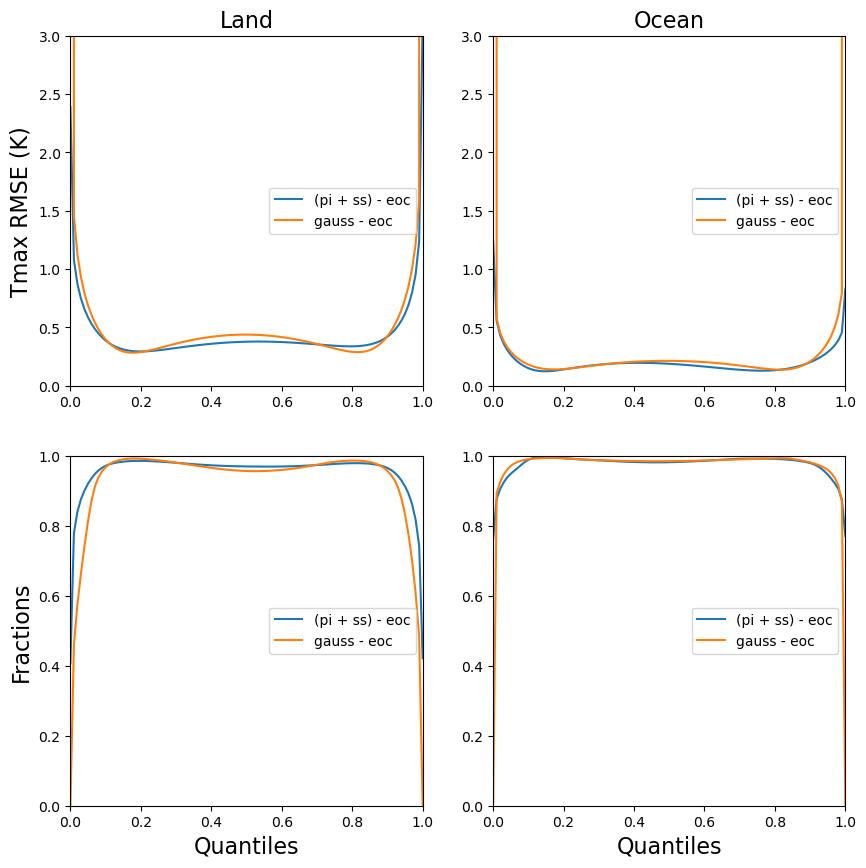

In [85]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

im1 = qgmsc_lrmse.plot(ax=axs[0,0],label='(pi + ss) - eoc')
qgauss_lrmse.plot(ax=axs[0,0],label='gauss - eoc')
axs[0,0].set_title('Land',fontsize=16)
axs[0,0].set_xlabel('')
axs[0,0].set_ylabel('Tmax RMSE (K)',fontsize=16)
axs[0,0].set_xlim(0.0,1.0)
axs[0,0].set_ylim(0.0,3.0)
axs[0,0].legend(loc='center right')
#
im2 = qgmsc_ormse.plot(ax=axs[0,1],label='(pi + ss) - eoc')
qgauss_ormse.plot(ax=axs[0,1],label='gauss - eoc')
axs[0,1].set_title('Ocean',fontsize=16)
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('')
axs[0,1].set_xlim(0.0,1.0)
axs[0,1].set_ylim(0.0,3.0)
axs[0,1].legend(loc='center right')
#
im3 = qgmsc_land_errfracn1.plot(ax=axs[1,0],label='(pi + ss) - eoc')
qgauss_land_errfracn1.plot(ax=axs[1,0],label='gauss - eoc')
axs[1,0].set_title('')
axs[1,0].set_xlabel('Quantiles',fontsize=16)
axs[1,0].set_ylabel('Fractions',fontsize=16)
axs[1,0].set_xlim(0.0,1.0)
axs[1,0].set_ylim(0.0,1.0)
axs[1,0].legend(loc='center right')
#
im4 = qgmsc_ocean_errfracn1.plot(ax=axs[1,1],label='(pi + ss) - eoc')
qgauss_ocean_errfracn1.plot(ax=axs[1,1],label='gauss - eoc')
axs[1,1].set_title('')
axs[1,1].set_xlabel('Quantiles',fontsize=16)
axs[1,1].set_ylabel('')
axs[1,1].set_xlim(0.0,1.0)
axs[1,1].set_ylim(0.0,1.0)
axs[1,1].legend(loc='center right')
# plot.show()

In [86]:
%%time
error_redn = qgmsc_grmse.integrate('quantile')/qgmc_grmse.integrate('quantile')
error_redn.values

CPU times: user 162 ms, sys: 13.5 ms, total: 176 ms
Wall time: 204 ms


array(0.36673206)

In [71]:
########## Check CLT ###########

In [72]:
%%time
tgmw_d  = to_daily(tgmw)
tgmw_d0 = tgmw_d.sel(year=slice(1850,1879))
tgmw_d1 = tgmw_d.sel(year=slice(ic_year0,ic_year1))
tgmw_d1 = tgmw_d1.chunk({'day':30})
tgmw_d1

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


CPU times: user 633 ms, sys: 9.01 ms, total: 642 ms
Wall time: 631 ms


,Array,Chunk
Bytes,225.56 GiB,20.60 MiB
Shape,"(192, 288, 100, 30, 365)","(20, 30, 100, 3, 30)"
Count,104902 Tasks,16900 Chunks
Type,float32,numpy.ndarray


In [ ]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants             = np.arange(0,1.01,0.01)
N_mem              = 100
window_len         = 30
#r = roll, ndrop = drop NANs
tgmw_eocroll       = stack_roll(tgmw_d1,N_mem*window_len,N_mem)
tgmw_piroll        = stack_roll(tgmw_d0,N_mem*window_len,N_mem)
#########
tgmw_eocroll0      = tgmw_eocroll.sel(ym=[15])
tgmw_piroll0       = tgmw_piroll.sel(ym=[15])
tgmw_piroll0

In [ ]:
tgmw_eocmroll = tgmw_eocroll0.mean('index')
tgmw_eocsroll = tgmw_eocroll0.std('index')
qgmw_eocroll  = tgmw_eocroll0.quantile(quants,dim='index',skipna=False)
######################

In [ ]:
# Generate normal distributions using means and standard deviations
index = np.arange(3000) 

gaussians_eoc = xr.apply_ufunc(
    np.random.normal,
    tgmw_eocmroll,
    tgmw_eocsroll,
    input_core_dims=[[], []],
    output_core_dims=[['index']],
    vectorize=True,
    output_dtypes=[float],
    kwargs={'size': 3000},
     output_sizes={'index': 3000},
    dask='parallelized'
)

In [ ]:
qgauss_eoc = gaussians_eoc.quantile(quants,dim='index',skipna=False)

In [ ]:
qgmw_gauss_diff   = qgauss_eoc - qgmw_eocroll

In [ ]:
### ###Save ######
qgmw_gauss_diffpath      = cvals+'qgmw_gauss_diff'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#qgmw_gauss_diff.to_dataset().to_zarr(qgmw_gauss_diffpath,mode='w')

In [ ]:
# qgmw_gauss_diff   = xr.open_zarr(qgmw_gauss_diff)
# qgmw_gauss_diff   = qgmw_gauss_diff.TREFHTMX

In [ ]:
qgmw_gesq                   = qgmw_gauss_diff**2
qgmw_gauss_serror_weighted  = qgmw_gesq.weighted(weights)
qgmw_gauss_serror_gmean     = qgmw_gauss_serror_weighted.mean({'lat','lon'})
################################################

In [ ]:
qgmw_gauss_gmse            = qgmw_gauss_serror_gmean.mean('day')
qgmw_gauss_grmse           = np.sqrt(qgmw_gauss_gmse)
qgmw_gauss_grmse 

In [ ]:
%%time
qgmw_gauss_grmsepath = cvals+'qgmw_gauss_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##########################
#qgmw_gauss_grmse.to_dataset().to_zarr(qgmw_gauss_grmsepath,mode='w')

In [ ]:
qgmw_gauss_grmse = xr.open_zarr(qgmw_gauss_grmsepath)
qgmw_gauss_grmse = qgmw_gauss_grmse.TREFHTMX

In [ ]:
%%time
plt.plot(quants,qgmw_grmse,label='eoc - pi',color='tab:blue')
plt.plot(quants,qgmw_gauss_grmse,label='eoc - gaussian',color='red')
plt.plot(quants,qgmc_grmse,label='eoc - (pi + shift)',color='tab:orange')
plt.plot(quants,qgmsc_grmse,label='eoc - (pi + shift + stretch)',color='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Global,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,5.0)
plt.show()